In [1]:
import time
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt

In [5]:
def RVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 85*np.pi / 180
    w1 = 2*np.pi / 60 #rad/sec
    w2 = 2*w1 #rad/sec
    w3 = 3.14159 / 60 #rad/sec
    
    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]
    
    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]
    
    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]
    
    D=[[np.cos(theta2)],
       [np.sin(theta2)*np.cos(w3*t)],
       [np.sin(theta2)*np.sin(w3*t)]]
    
    result1 = np.matmul(A,B)
    result2 = np.matmul(result1,C)
    result = np.matmul(result2,D)

    return result

In [6]:
def SVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 0
    w1 = 2*np.pi / 60 #rad/sec
    # w1 = 0.000011954 / 60 #rad/sec
    w2 = 2*w1  #rad/sec
    w3 = 3.14159 / 60 #rad/sec
    
    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]
    
    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]
    
    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]
    
    D=[[np.cos(theta2)],
       [-np.sin(theta2)*np.cos(w3*t)],
       [-np.sin(theta2)*np.sin(w3*t)]]
    
    result1 = np.dot(A,B)
    result2 = np.dot(C,D)
    result = np.dot(result1,result2)
    return result

In [7]:
theta1 = 7.5*np.pi / 180
theta2 = 85*np.pi / 180
w1 = 2*np.pi / 60 #rad/sec
w2 = 2*w1 #rad/sec
w3 = 3.14159 / 60 #rad/sec

nside=1024
npix = 12*nside**2

# time_step=scan_time
scan_time = np.sqrt(4*np.pi/npix)/w1
print("scan time = ",scan_time,"(in sec)")

fwhm=45 # Example (in degree)
sigma = fwhm / np.sqrt(8 * np.log(2)) 


scan time =  0.009543017810603906 (in sec)


setting the output map dtype to [dtype('float64')]


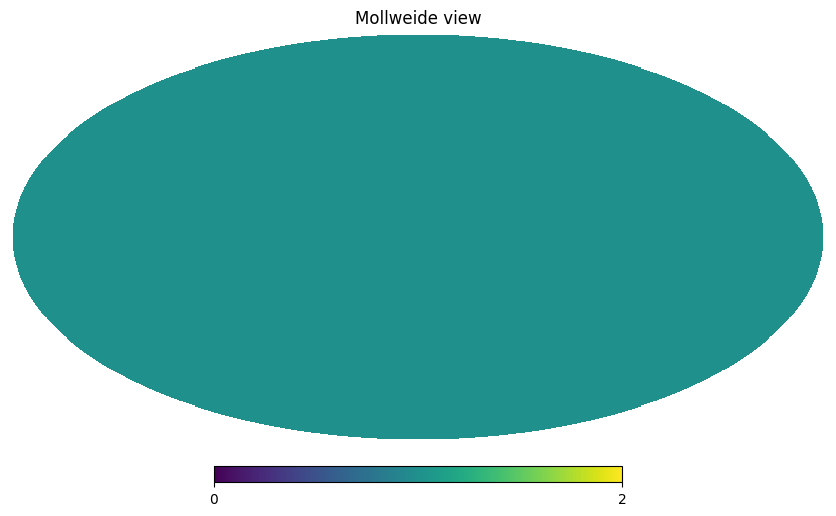

In [8]:
# To generate unit temperature map
map_array = np.ones(npix) # Creates an array filled with 1s
# map_array = np.linspace(0,npix,npix)
map = hp.ma(map_array)  # Creates a Healpix map from the array
hp.write_map("map_in_fits.fits", map, overwrite=True,)
hp.mollview(map)

In [7]:
# angular saperation between two pixel
def ang_distance(theta1,theta2,phi1,phi2):
    # cos(∆θ) = sin(θ1)sin(θ2)cos(φ1 - φ2) + cos(θ1)cos(θ2)
    theta = np.arccos(np.cos(theta1) * np.cos(theta2) + np.sin(theta1) * np.sin(theta2) * np.cos(phi1 - phi2))
    return theta

In [8]:
temperature_map = hp.read_map("map_in_fits.fits", nest=True)

def process_time_step(time_step):
    
    t = time_step  

    # 1. Calculate R(t) and S(t) vectors
    R = RVector(t)
    S = SVector(t)

    # 2. Calculate pixel number along R(t) vector (ring format)
    theta_R, phi_R = hp.vec2ang(R)
    pic_ring = hp.ang2pix(nside, theta=theta_R, phi=phi_R)

    # 3. Convert to NEST format
    nest_pix = hp.ring2nest(nside, pic_ring)

    # 4. Find neighboring pixels in NEST format
    # neighbours = hp.get_all_neighbours(nside, nest_pix,nest=True)
    neighbours = hp.query_disc(nside, R , radius=np.radians(0.75),nest = True)

    # 5. angular separation central pixel to neighbor
    # theta_separations = np.zeros_like(neighbours)
    # for i, neighbour_pix in enumerate(neighbours):
    #     theta_neighbour, phi_neighbour = hp.pix2ang(nside, neighbour_pix)
    #     theta_separations[i] = ang_distance(theta_R, theta_neighbour, phi_R, phi_neighbour) 

    # # 6. Retrieve temperatures of neighboring pixels
    # # temperature_map = hp.read_map("map_in_fits.fits", verbose=False) 
    # neighbor_temperatures = temperature_map[neighbours]

    # # 7. Apply the beam convolution
    # convolved_temperature = np.sum(neighbor_temperatures * np.exp(-theta_separations**2 / (2 * sigma**2))) / np.sum(np.exp(-theta_separations**2 / (2 * sigma**2)))
    convolved_temperature=1
    # 8. Store the convolved temperature and pixel in a .dat file
    # temperature_data.append((nest_pix, convolved_temperature))
    # with open("temperature.dat", "a") as f:  # Open in append mode
    #     f.write(f"{int(nest_pix)} {convolved_temperature:.4f}\n")

    return int(nest_pix),convolved_temperature
print(scan_time)

0.009543017810603906


In [ ]:
# Example time steps
start = time.time()

start_time=1900800
duration = 60*60*24*40 #in sec
steps = int(duration / scan_time)

# time_periods = np.linspace(0,steps*scan_time, steps)
time_periods = np.linspace(start_time, start_time + steps*scan_time, steps)
print(steps)

with open("temperature20_60.dat", "a") as f:  
    for time_period in time_periods:
        pixel,temperature = process_time_step(time_period)
        f.write(f"{time_period:.4f} {pixel} {temperature}\n")
        

end = time.time()
elapsed_time = end - start
print(f"Total execution time: {elapsed_time:.2f} seconds")

362149591


/tmp/ipykernel_2564/2892261018.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neighbours = hp.query_disc(nside, R , radius=np.radians(0.75),nest = True)
/tmp/ipykernel_2564/2892261018.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(nest_pix),convolved_temperature


In [ ]:
with open("4temperature.dat", "r") as f:
    lines = f.readlines()

unique_pixels = set()
unique_lines = []

for line in lines:
    time, pixel, temperature = line.split()  # Split into three columns
    if pixel not in unique_pixels:
        unique_pixels.add(pixel)
        unique_lines.append(line)

with open("temperature_unique.dat", "w") as f:
    f.writelines(unique_lines)


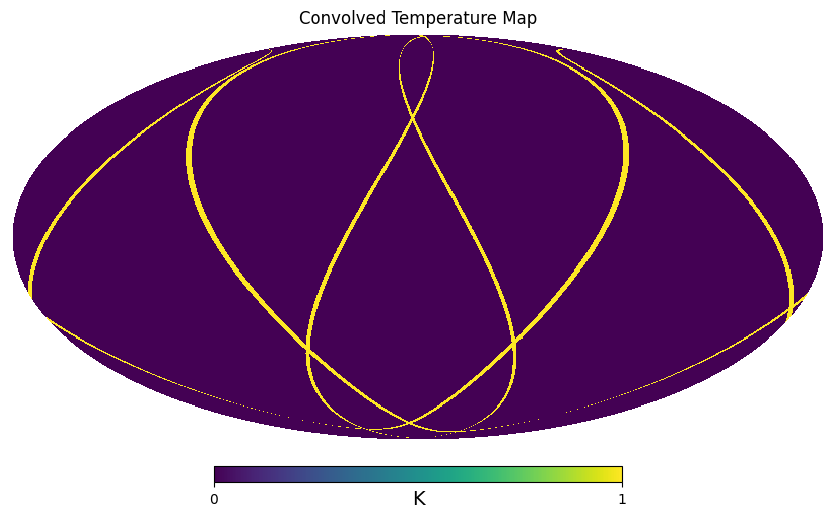

In [8]:
# 1. Load the data
data = np.loadtxt("temperature20_60.dat")
pixels, temperatures4 = data[:, 1].astype(int), data[:, 2]

# 2. Create a Healpix map with zeros
map_array = np.zeros(npix)

# 3. Fill in available pixels with temperatures
map_array[pixels] = temperatures4
# map=np.linspace(0, npix, npix)

hp.mollview(map_array,nest=True, title="Convolved Temperature Map", unit="K")
# hp.graticule()
plt.savefig("convolved_temperature_map.png")
plt.show()

In [ ]:

import os
# Open the target file for writing
with open("combined_temperature.dat", "w") as combined_file:
    for i in range(1, 5):
        # Open each individual file
        with open(f"{i}temperature.dat", "r") as individual_file:
            # Read the entire content
            content = individual_file.read()
            # Write the content to the combined file
            combined_file.write(content)

print("Data combined successfully!")


In [ ]:
all_pixels = []
all_temperatures = []
for i in range(1, 5):
    data = np.loadtxt(f"{i}temperature.dat")
    pixels, temperatures = data[:, 1].astype(int), data[:, 2]
    all_pixels.extend(pixels)
    all_temperatures.extend(temperatures)

# Create the Healpix map
map_array = np.zeros(npix)
map_array[all_pixels] = all_temperatures

# Plot the map
# map = np.linspace(0, npix, npix)  # Not sure how this is used in your plot
hp.mollview(map_array, nest=True, title="Convolved Temperature Map", unit="K")
# hp.graticule()
plt.savefig("convolved_temperature_map.png")
plt.show()

In [ ]:
print(len(all_pixels))

In [ ]:
# Generate time points
t = time_periods
# Calculate resulting vectors
vectors1 = [RVector(ti) for ti in t]
vectors2 = [SVector(ti) for ti in t]

# Extract components
x1 = [vector[0] for vector in vectors1]
y1 = [vector[1] for vector in vectors1]
z1 = [vector[2] for vector in vectors1]
x2 = [vector[0] for vector in vectors2]
y2 = [vector[1] for vector in vectors2]
z2 = [vector[2] for vector in vectors2]

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, y1, z1)
ax.scatter(x2, y2, z2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [9]:
# For vizualization of neighbouring pixels
nside = 64
t=20
R = RVector(t)

theta_R, phi_R = hp.vec2ang(R)
pic_ring = hp.ang2pix(nside, theta=theta_R, phi=phi_R)
nest_pix = hp.ring2nest(nside, pic_ring)


get_all = hp.get_all_neighbours(nside, nest_pix,nest=True)
query_disc1 = hp.query_disc(nside, R , radius=np.radians(5),inclusive=True,nest=True)
query_disc2 = hp.query_disc(nside, R , radius=np.radians(5),inclusive=False,nest=True)

print("get_all_neighbours: ",len(get_all))
print("query_disc(inclusive=True): ",len(query_disc1))
print("query_disc(inclusive=False): ",len(query_disc2))

get_all_neighbours:  8
query_disc(inclusive=True):  120
query_disc(inclusive=False):  95


/tmp/ipykernel_2354/1076701818.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  query_disc1 = hp.query_disc(nside, R , radius=np.radians(5),inclusive=True,nest=True)
/tmp/ipykernel_2354/1076701818.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  query_disc2 = hp.query_disc(nside, R , radius=np.radians(5),inclusive=False,nest=True)


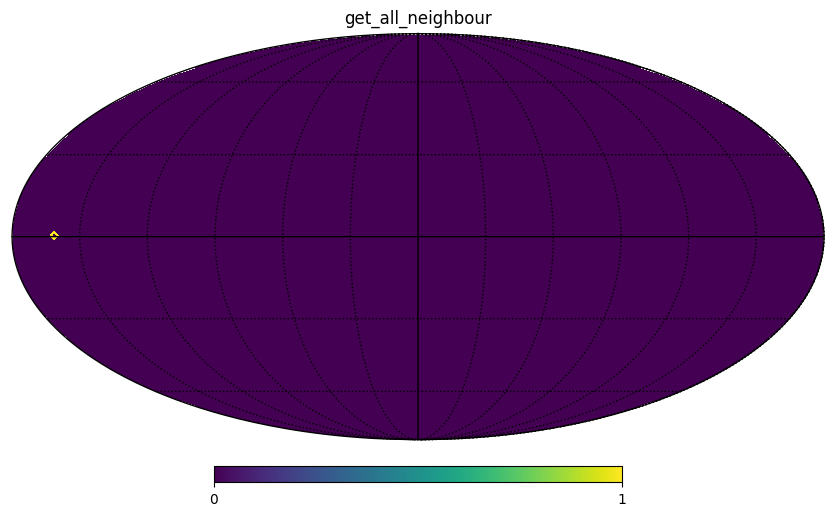

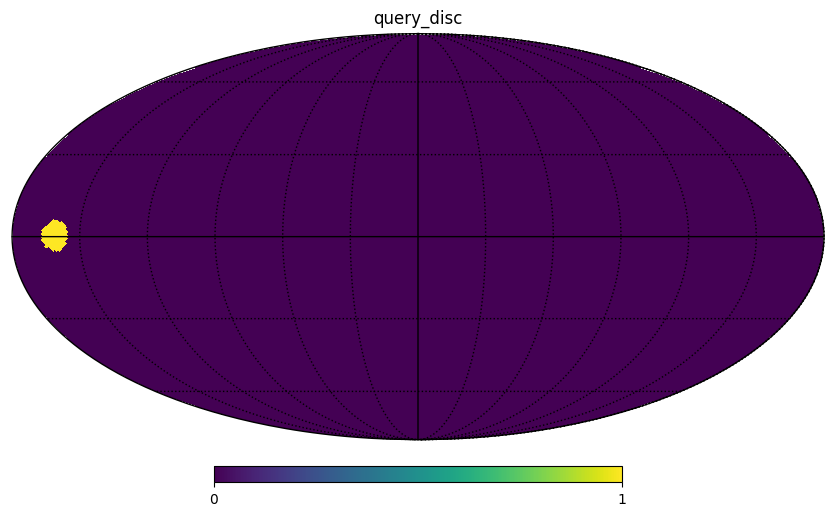

In [10]:

npix = hp.nside2npix(nside) 
map_array1 = np.zeros(npix)
map_array2 = np.zeros(npix)
map_array3 = np.zeros(npix)

map_array1[get_all] = 1
map_array2[query_disc1] = 1
map_array3[query_disc2] = 1

hp.mollview(map_array1,title="get_all_neighbour",nest=True) 
hp.graticule()
hp.mollview(map_array2,title="query_disc",nest=True)
hp.graticule()
plt.show()
